UTILS


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Apr 24 22:02:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import zipfile

# Specify the path to the ZIP file
zip_path = '/content/drive/MyDrive/basic/Image/aligned.zip'

# Specify the path to the destination folder
dest_path = '/content/aligned'

# Open the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract the contents of the subfolder to the destination folder
    zip_ref.extractall(dest_path)


In [ ]:
class Args():

    def __init__(self):
      self.raf_path = '/content/drive/MyDrive/basic'
      self.resnet50_path ='/content/drive/MyDrive/resnet50_ft_weight (1).pkl'
      self.label_path = 'list_patition_label.txt'
      self.workers = 4
      self.batch_size= 32
      self.w =7
      self.h = 7
      self.gpu = 0
      self.lam = 5.0
      self.epochs = 60

args = Args()

In [ ]:
import torch
import cv2
import numpy as np
import random


In [ ]:
def add_g(image_array, mean=0.0, var=30):
    std = var ** 0.5
    image_add = image_array + np.random.normal(mean, std, image_array.shape)
    image_add = np.clip(image_add, 0, 255).astype(np.uint8)
    return image_add

In [ ]:
def flip_image(image_array):
    return cv2.flip(image_array, 1)

In [ ]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
def generate_flip_grid(w, h, device):
    # used to flip attention maps
    x_ = torch.arange(w).view(1, -1).expand(h, -1)
    y_ = torch.arange(h).view(-1, 1).expand(-1, w)
    grid = torch.stack([x_, y_], dim=0).float().to(device)
    grid = grid.unsqueeze(0).expand(1, -1, -1, -1)
    grid[:, 0, :, :] = 2 * grid[:, 0, :, :] / (w - 1) - 1
    grid[:, 1, :, :] = 2 * grid[:, 1, :, :] / (h - 1) - 1
    grid[:, 0, :, :] = -grid[:, 0, :, :]
    return grid

DATASET CLASS

In [ ]:
import os
import cv2
import torch.utils.data as data
import pandas as pd
import random
from torchvision import transforms

In [ ]:
class RafDataset(data.Dataset):
    def __init__(self, args, phase, basic_aug=True, transform=None):
        self.raf_path = args.raf_path
        self.phase = phase
        self.basic_aug = basic_aug
        self.transform = transform
        df = pd.read_csv(os.path.join(self.raf_path, 'EmoLabel', args.label_path), sep=' ', header=None)

        name_c = 0
        label_c = 1
        if phase == 'train':
            dataset = df[df[name_c].str.startswith('train')]
        else:
            df = pd.read_csv(os.path.join(self.raf_path, 'EmoLabel/list_patition_label.txt'), sep=' ', header=None)
            dataset = df[df[name_c].str.startswith('test')]

        self.label = dataset.iloc[:, label_c].values - 1
        images_names = dataset.iloc[:, name_c].values
        self.aug_func = [flip_image, add_g]
        self.file_paths = []
        self.clean = (args.label_path == 'list_patition_label.txt')

        for f in images_names:
            f = f.split(".")[0]
            f += '_aligned.jpg'
            file_name = os.path.join('/content/aligned/aligned', f)
            self.file_paths.append(file_name)


    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.label[idx]
        image = cv2.imread(self.file_paths[idx])

        image = image[:, :, ::-1]


        if not self.clean:
            image1 = image
            image1 = self.aug_func[0](image)
            image1 = self.transform(image1)

        if self.phase == 'train':
            if self.basic_aug and random.uniform(0, 1) > 0.5:
                image = self.aug_func[1](image)

        if self.transform is not None:
            image = self.transform(image)

        if self.clean:
            image1 = transforms.RandomHorizontalFlip(p=1)(image)

        return image, label, idx, image1

In [ ]:
label_file ="/content/drive/MyDrive/basic/EmoLabel/list_patition_label.txt"
alignedimages_file = "/content/drive/MyDrive/basic/Image/aligned.zip"
train_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(scale=(0.02, 0.25)) ])

train_dataset = RafDataset(args, phase='train', transform= train_transforms)
len(train_dataset)
#test_dataset = RafDataset(args, phase='test', transform=eval_transforms)

12271

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=args.batch_size,
                                               shuffle=True,
                                               num_workers=args.workers,
                                               pin_memory=True)
images,labels,idx,images1 = next(iter(train_loader))

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/basic/EmoLabel/list_patition_label.txt", delim_whitespace=True, header=None)
print(df.iloc[:,0])

0        train_00001.jpg
1        train_00002.jpg
2        train_00003.jpg
3        train_00004.jpg
4        train_00005.jpg
              ...       
15334      test_3064.jpg
15335      test_3065.jpg
15336      test_3066.jpg
15337      test_3067.jpg
15338      test_3068.jpg
Name: 0, Length: 15339, dtype: object


ResNet


In [ ]:
import torch
import torch.nn as nn
import math

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=8631, include_top=True):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.include_top = include_top

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        if not self.include_top:
            return x

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:
if __name__ == '__main__':
    res18 = ResNet(block=BasicBlock, n_blocks=[2, 2, 2, 2], channels=[64, 128, 256, 512], output_dim=1000)
    input = torch.randn(1, 3, 224, 224)
    output = res18(input)
    print(output.size())

TypeError: ignored

MODEL

In [ ]:
import pickle
import torchvision.models as mo
from torch.autograd import Variable

In [ ]:
class Model(nn.Module):


    def __init__(self, args, pretrained=True, num_classes=7):
        super(Model, self).__init__()
        resnet50 = ResNet(Bottleneck, [3, 4, 6, 3])
        with open(args.resnet50_path, 'rb') as f:
            obj = f.read()
        weights = {key: torch.from_numpy(arr) for key, arr in pickle.loads(obj, encoding='latin1').items()}
        resnet50.load_state_dict(weights)

        self.features = nn.Sequential(*list(resnet50.children())[:-2])
        self.features2 = nn.Sequential(*list(resnet50.children())[-2:-1])
        self.fc = nn.Linear(2048, 7)



    def forward(self, x):
        x = self.features(x)
        #### 1, 2048, 7, 7
        feature = self.features2(x)
        #### 1, 2048, 1, 1

        feature = feature.view(feature.size(0), -1)
        output = self.fc(feature)

        params = list(self.parameters())
        fc_weights = params[-2].data
        fc_weights = fc_weights.view(1, 7, 2048, 1, 1)
        fc_weights = Variable(fc_weights, requires_grad = False)

        # attention
        feat = x.unsqueeze(1) # N * 1 * C * H * W
        hm = feat * fc_weights
        hm = hm.sum(2) # N * self.num_labels * H * W

        return output, hm

ACL


In [ ]:
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
def ACLoss(att_map1, att_map2, grid_l, output):
    flip_grid_large = grid_l.expand(output.size(0), -1, -1, -1)
    flip_grid_large = Variable(flip_grid_large, requires_grad = False)
    flip_grid_large = flip_grid_large.permute(0, 2, 3, 1)
    att_map2_flip = F.grid_sample(att_map2, flip_grid_large, mode = 'bilinear', padding_mode = 'border', align_corners=True)
    flip_loss_l = F.mse_loss(att_map1, att_map2_flip)
    return flip_loss_l

In [ ]:
import os
import cv2
import csv
import math
import random
import numpy as np
import pandas as pd
import argparse
import pickle

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
import torch.utils.data as data
import torch.nn.functional as F

In [ ]:
def train(args, model, train_loader, optimizer, scheduler, device):
    running_loss = 0.0
    iter_cnt = 0
    correct_sum = 0

    model.to(device)
    model.train()

    total_loss = []
    for batch_i, (imgs1, labels, indexes, imgs2) in enumerate(train_loader):
        imgs1 = imgs1.to(device)
        imgs2 = imgs2.to(device)
        labels = labels.to(device)


        criterion = nn.CrossEntropyLoss(reduction='none')



        output, hm1 = model(imgs1)
        output_flip, hm2 = model(imgs2)

        grid_l = generate_flip_grid(args.w, args.h, device)


        loss1 = nn.CrossEntropyLoss()(output, labels)
        flip_loss_l = ACLoss(hm1, hm2, grid_l, output)


        loss = loss1 + args.lam * flip_loss_l


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        iter_cnt += 1
        _, predicts = torch.max(output, 1)
        correct_num = torch.eq(predicts, labels).sum()
        correct_sum += correct_num
        running_loss += loss

    scheduler.step()
    running_loss = running_loss / iter_cnt
    acc = correct_sum.float() / float(train_loader.dataset.__len__())
    torch.save(model.state_dict, "EAC.pth")
    return acc, running_loss, model

In [ ]:
def test(model, test_loader, device):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        iter_cnt = 0
        correct_sum = 0
        data_num = 0


        for batch_i, (imgs1, labels, indexes, imgs2) in enumerate(test_loader):
            imgs1 = imgs1.to(device)
            labels = labels.to(device)


            outputs, _ = model(imgs1)


            loss = nn.CrossEntropyLoss()(outputs, labels)

            iter_cnt += 1
            _, predicts = torch.max(outputs, 1)

            correct_num = torch.eq(predicts, labels).sum()
            correct_sum += correct_num

            running_loss += loss
            data_num += outputs.size(0)

        running_loss = running_loss / iter_cnt
        test_acc = correct_sum.float() / float(data_num)
    return test_acc, running_loss

In [ ]:
import torchvision

setup_seed(0)

train_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(scale=(0.02, 0.25)) ])

eval_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])



train_dataset = RafDataset(args, phase='train', transform=train_transforms)
test_dataset = RafDataset(args, phase='test', transform=eval_transforms)



train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=args.batch_size,
                                               shuffle=True,
                                               num_workers=args.workers,
                                               pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                              shuffle=False,
                                              num_workers=args.workers,
                                              pin_memory=True)

model = Model(args)

device = torch.device ('cuda:0' if torch.cuda.is_available() else 'cpu')

optimizer = torch.optim.Adam(model.parameters() , lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)





for i in range(1, 41):
    train_acc, train_loss, model = train(args, model, train_loader, optimizer, scheduler, device)
    test_acc, test_loss = test(model, test_loader, device)
    with open('rebuttal_50_noise_1'+str(args.label_path)+'.txt', 'a') as f:
        f.write(str(i)+'_'+str(test_acc)+'_'+str(train_acc)+'\n')
    print('Accuracy after epoch_'+ str(i) +' :'+'Training_data_accuracy :'+ str(train_acc)+','+'Test_data_accuracy :'+ str(test_acc))
    torch.save(model.state_dict(), "EAC.pth")



Accuracy after epoch_1 :Training_data_accuracy :tensor(0.6704, device='cuda:0'),Test_data_accuracy :tensor(0.7888, device='cuda:0')
Accuracy after epoch_2 :Training_data_accuracy :tensor(0.7842, device='cuda:0'),Test_data_accuracy :tensor(0.8321, device='cuda:0')
Accuracy after epoch_3 :Training_data_accuracy :tensor(0.8214, device='cuda:0'),Test_data_accuracy :tensor(0.8380, device='cuda:0')
Accuracy after epoch_4 :Training_data_accuracy :tensor(0.8451, device='cuda:0'),Test_data_accuracy :tensor(0.8546, device='cuda:0')
Accuracy after epoch_5 :Training_data_accuracy :tensor(0.8636, device='cuda:0'),Test_data_accuracy :tensor(0.8706, device='cuda:0')
Accuracy after epoch_6 :Training_data_accuracy :tensor(0.8770, device='cuda:0'),Test_data_accuracy :tensor(0.8787, device='cuda:0')
Accuracy after epoch_7 :Training_data_accuracy :tensor(0.8919, device='cuda:0'),Test_data_accuracy :tensor(0.8745, device='cuda:0')
Accuracy after epoch_8 :Training_data_accuracy :tensor(0.9060, device='cuda:

In [ ]:
import torch
torch.save(model.state_dict(), "EAC.pth")


In [ ]:
# Load the state dictionary object from file
state_dict = torch.load('/content/EAC.pth')

# Check the type of the state dictionary object
print(type(state_dict))

# Check the keys of the state dictionary object
print(state_dict.keys())


<class 'collections.OrderedDict'>
odict_keys(['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.4.0.conv1.weight', 'features.4.0.bn1.weight', 'features.4.0.bn1.bias', 'features.4.0.bn1.running_mean', 'features.4.0.bn1.running_var', 'features.4.0.bn1.num_batches_tracked', 'features.4.0.conv2.weight', 'features.4.0.bn2.weight', 'features.4.0.bn2.bias', 'features.4.0.bn2.running_mean', 'features.4.0.bn2.running_var', 'features.4.0.bn2.num_batches_tracked', 'features.4.0.conv3.weight', 'features.4.0.bn3.weight', 'features.4.0.bn3.bias', 'features.4.0.bn3.running_mean', 'features.4.0.bn3.running_var', 'features.4.0.bn3.num_batches_tracked', 'features.4.0.downsample.0.weight', 'features.4.0.downsample.1.weight', 'features.4.0.downsample.1.bias', 'features.4.0.downsample.1.running_mean', 'features.4.0.downsample.1.running_var', 'features.4.0.downsample.1.num_batches_tracked', 'features.

In [ ]:
import os

# Get the path to the file
file_path = "/content/drive/MyDrive/resnet50_ft_weight (1).pkl"

# Get the size of the file in bytes
file_size = os.path.getsize(file_path)

# Print the file size in bytes
print("File size:", file_size, "bytes")

# Convert the file size to kilobytes
file_size_kb = file_size / 1024
print("File size:", file_size_kb, "KB")

# Convert the file size to megabytes
file_size_mb = file_size / (1024 * 1024)
print("File size:", file_size_mb, "MB")


File size: 165000856 bytes
File size: 161133.6484375 KB
File size: 157.3570785522461 MB


In [ ]:
# Load the state dictionary object from file
state_dict = torch.load('/content/EAC.pth')

# Check the type of the state dictionary object
print(type(state_dict))

# Check the keys of the state dictionary object
#print(state_dict.keys())


<class 'method'>


In [ ]:
setup_seed(0)

eval_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])




test_dataset = RafDataset(args, phase='test', transform=eval_transforms)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                              shuffle=False,
                                              num_workers=2,
                                              pin_memory=True)

device = torch.device ('cuda:0' if torch.cuda.is_available() else 'cpu')



model = Model(args)
model.load_state_dict(torch.load('/content/EAC_Final.pth'))


model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch_i, (imgs1, labels, indexes, imgs2) in enumerate(test_loader):
        imgs1 = imgs1.to(device)
        labels = labels.to(device)
        model= model.to(device)
        outputs1, _ = model(imgs1)
        _, predicted = torch.max(outputs1, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of model is : {} %' .format(100*correct/total))

Accuracy of model is : 90.48239895697523 %


In [ ]:
model = Model(args)
model.load_state_dict(torch.load('/content/EAC_Final.pth'))


<All keys matched successfully>

In [ ]:
nb_classes = 7
eval_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

device = torch.device ('cuda:0' if torch.cuda.is_available() else 'cpu')
test_dataset = RafDataset(args, phase='test', transform=eval_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                              shuffle=False,
                                              num_workers=2,
                                              pin_memory=True)
confusion_matrix = torch.zeros(nb_classes, nb_classes)
model.eval()
with torch.no_grad():
    for i, (images, labels,indexes,img1) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs,_ = model(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([[2.8500e+02, 8.0000e+00, 3.0000e+00, 5.0000e+00, 3.0000e+00, 9.0000e+00,
         1.6000e+01],
        [9.0000e+00, 5.0000e+01, 1.0000e+00, 3.0000e+00, 7.0000e+00, 2.0000e+00,
         2.0000e+00],
        [3.0000e+00, 1.0000e+00, 1.1900e+02, 8.0000e+00, 9.0000e+00, 1.0000e+01,
         1.0000e+01],
        [4.0000e+00, 1.0000e+00, 7.0000e+00, 1.1390e+03, 5.0000e+00, 3.0000e+00,
         2.6000e+01],
        [0.0000e+00, 3.0000e+00, 1.1000e+01, 8.0000e+00, 4.2000e+02, 1.0000e+00,
         3.5000e+01],
        [2.0000e+00, 1.0000e+00, 7.0000e+00, 2.0000e+00, 1.0000e+00, 1.4000e+02,
         9.0000e+00],
        [9.0000e+00, 0.0000e+00, 9.0000e+00, 1.8000e+01, 2.1000e+01, 0.0000e+00,
         6.2300e+02]])
tensor([0.8663, 0.6757, 0.7437, 0.9612, 0.8787, 0.8642, 0.9162])


Text(0.5, 80.7222222222222, 'Predicted label')

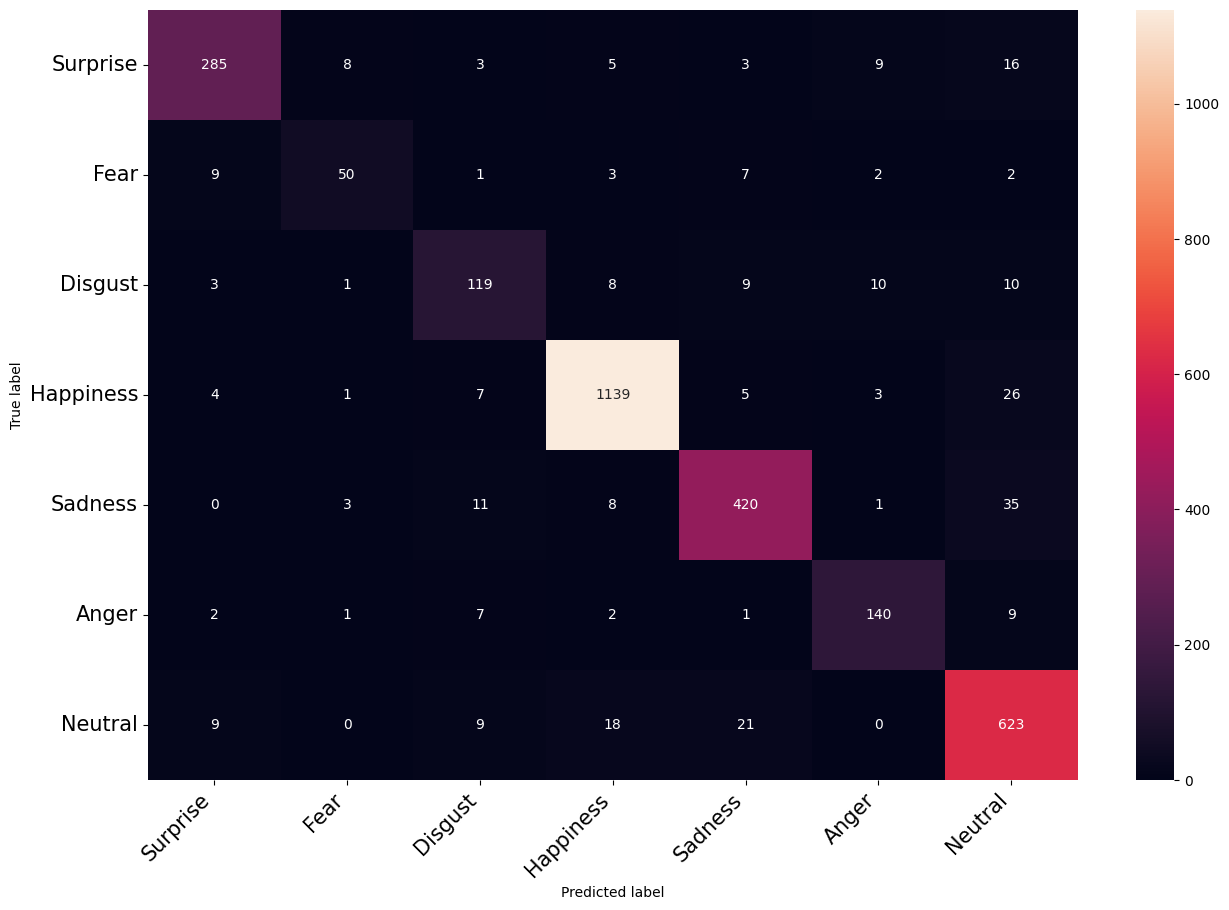

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(15,10))


class_names = ['Surprise' , 'Fear' , 'Disgust' , 'Happiness' , 'Sadness' ,'Anger' ,'Neutral']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
